<h1>Higgs Boson Challenge</h1>
<img src="images/title.png" alt="Drawing" style="width: 350px;">

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from prepare import prepare_data
from model import Model
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import xgboost as xgb
from viz_tools import collision_plot, collide_animation


import matplotlib
from matplotlib import animation

<h1>The Problem</h1>

In [2]:
%matplotlib notebook

In [3]:
##############
#### REQUIRED FOR ANIMATION
##############

df = pd.read_csv("/home/jmenard/McGill_PhysicsHack/atlas-higgs-challenge-2014-v2.csv")

def invert_eta(eta):
    # pseudorapidity η = −ln tan(θ/2);
    theta = 2* np.arctan( np.exp(-1*eta) )
    return theta

#numPts = 6
startPt = np.random.randint(0,10000)
numPts = startPt+1


def grab_event(df, start_row, event_type="s", particle_type="lep"):
    """
    start_row : int element of [0, df.shape[0]]
    event_type : str, {"s", "b"}
    particle_type : str, {
                        "lep", "tau", 
                        "met", "jet_leading",
                        "jet_subleading"
                        }
        lep = Lepton
        tau = Tau
        met = Missing Transverse Energy
    """
    
    _eta = "PRI_" + particle_type + "_eta"
    _phi = "PRI_" + particle_type + "_phi"
    _pt = "PRI_" + particle_type + "_pt"
    
    particle = df[df["Label"] == event_type]#[[_eta, _phi, _pt]]
    phi      = particle[_phi].values[start_row]
    theta    = invert_eta( particle[_eta].values[start_row] )
    trans_p  = particle[_pt].values[start_row]
    
    return theta, phi, trans_p 

def sph2cart(theta, phi, r):
    x = r * np.multiply( np.sin(phi), np.cos(theta) )
    y = r * np.multiply( np.sin(phi),np.sin(theta) )
    z = r * np.cos(phi)
    return (x, y, z)

def plot_wrapper(df, event_id,ax):

    thetaLep_b, phiLep_b, _ = grab_event(df, event_id, event_type="b", particle_type="lep")
    thetaTau_b, phiTau_b, _ = grab_event(df, event_id, event_type="b", particle_type="tau")
    thetaLep_s, phiLep_s, _ = grab_event(df, event_id, event_type="s", particle_type="lep")
    thetaTau_s, phiTau_s, _ = grab_event(df, event_id, event_type="s", particle_type="tau")
    
    collision_plot( (thetaLep_b, phiLep_b, thetaTau_b, phiTau_b),
                    (thetaLep_s, phiLep_s, thetaTau_s, phiTau_s),ax
                  )    


def collision_plot(background, signal,ax):
    """
    background --> ( thetaLep, phiLep, thetaTau, phiTau )
    signal     --> ( thetaLep, phiLep, thetaTau, phiTau )
    """
    thetaLep_b, phiLep_b, thetaTau_b, phiTau_b = background
    thetaLep_s, phiLep_s, thetaTau_s, phiTau_s   = signal
    
    #fig1 = plt.figure(figsize=(5,5))
    #ax = Axes3D(fig1)
    #ax = plt.axes(projection='3d')
    
    #ax.plot3D(xline, yline, zline, 'gray')
    
    
    xbLep, ybLep, zbLep = sph2cart(thetaLep_b, phiLep_b, 1)
    xsLep, ysLep, zsLep = sph2cart(thetaLep_s, phiLep_s, 1)
    xbTau, ybTau, zbTau = sph2cart(thetaTau_b, phiTau_b, 1)
    xsTau, ysTau, zsTau = sph2cart(thetaTau_s, phiTau_s, 1)

    
    # draw sphere
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_wireframe(x, y, z, color="black",alpha=0.1)

    #ax.scatter3D(xbLep, ybLep, zbLep,c="red")#, c=z, cmap='Greens');
    #ax.scatter3D(xsLep, ysLep, zsLep,c="green")#, c=z, cmap='Greens');
    #ax.scatter3D(xbTau, ybTau, zbTau,c="Blue")#, c=z, cmap='Greens');
    #ax.scatter3D(xsTau, ysTau, zsTau,c="orange")#, c=z, cmap='Greens');

    ax.scatter3D(xbLep, zbLep, ybLep,c="red")#, c=z, cmap='Greens');
    ax.scatter3D(xsLep, zsLep, ysLep,c="blue")#, c=z, cmap='Greens');
    ax.scatter3D(xbTau, zbTau, ybTau,c="red")#, c=z, cmap='Greens');
    ax.scatter3D(xsTau, zsTau, ysTau,c="blue")#, c=z, cmap='Greens');


    #ax.plot3D([0,xbLep], [0,ybLep], [0,zbLep],label="lep b",c="red")#, c=z, cmap='Greens');
    #ax.plot3D([0,xsLep], [0,ysLep], [0,zsLep],label="lep s",c="green")#, c=z, cmap='Greens');
    #ax.plot3D([0,xbTau], [0,ybTau], [0,zbTau],label="Tau b",c="Blue")#, c=z, cmap='Greens');
    #ax.plot3D([0,xsTau], [0,ysTau], [0,zsTau],label="Tau s",c="orange")#, c=z, cmap='Greens');

    ax.plot3D([0,xbLep], [0,zbLep], [0,ybLep],label="lep b",linestyle="--",c="red")#, c=z, cmap='Greens');
    ax.plot3D([0,xsLep], [0,zsLep], [0,ysLep],label="lep s",linestyle="--",c="blue")#, c=z, cmap='Greens');
    ax.plot3D([0,xbTau], [0,zbTau], [0,ybTau],label="Tau b",c="red")#, c=z, cmap='Greens');
    ax.plot3D([0,xsTau], [0,zsTau], [0,ysTau],label="Tau s",c="blue")#, c=z, cmap='Greens');
    ax.plot3D([0,0], [-2,2], [0,0],c="black",alpha=0.3)#, c=z, cmap='Greens');
    plt.ylim(-1,1)
    
    #ax.view_init(elev=25, azim=-15)
    plt.legend()
    plt.title("Lab Frame")
    #plt.show()


<IPython.core.display.Javascript object>


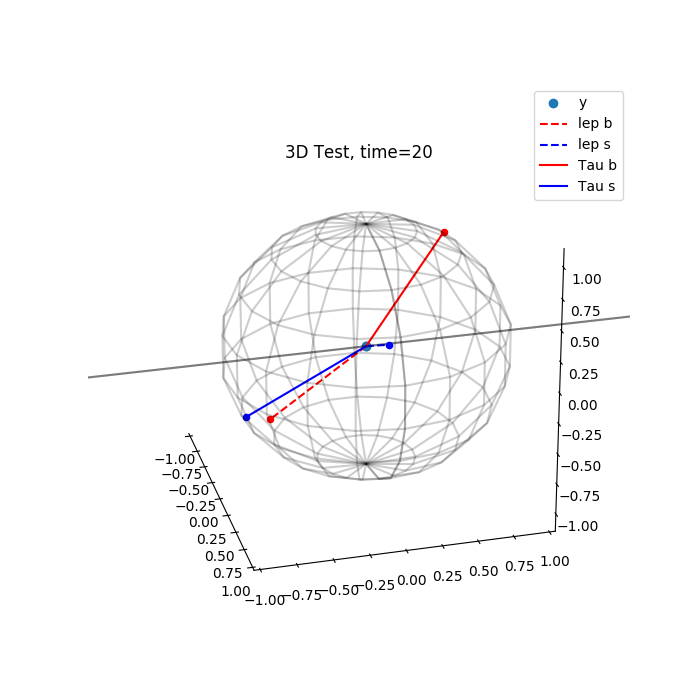

In [5]:
#######
### RUN ANIMATION
#######
b = np.array([list(np.arange(-1,0,0.05)), list(np.arange(1,0,-0.05))])
b.shape
b.flatten(order="F")
temp = np.array([list(np.arange(-1,0.05,0.05)), list(np.arange(1,-0.05,-0.05))]).flatten(order="F")
a = np.array([[0]*42, list(temp), [0]*42 ]).T
t = np.array([np.ones(2)*i for i in range(21)]).flatten()
tst = pd.DataFrame( {"time": t, "x" : a[:,0], "y":a[:,1], "z" : a[:,2]} )

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('3D Test')
xtot = 0
ztot=0
def update_graph(num):
    data=tst[tst['time']==num]
    global xtot
    xtot+=1
    if xtot>21:
        plot_wrapper(df, 101,ax)
    ztot=0
    graph.set_data (data.x, data.y)
    graph.set_3d_properties( np.array([ztot]) )
    title.set_text('3D Test, time={}'.format(num))
    return title, graph, 


# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color="black",alpha=0.1)

data=tst[tst['time']==0]
graph, = ax.plot(data.x, data.y, data.z, linestyle="", marker="o")
ax.plot3D([0,0], [-2,2], [0,0],c="black",alpha=0.3)
ani = animation.FuncAnimation(fig, update_graph, 21, 
                               interval=20, blit=True,repeat=False)
ax.view_init(elev=25, azim=-15)

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

What we achieved
====

* Understanding of the experimental particle detection setup
* The meaning of the measurements
* Data visualization
* Training extreme gradient boosting models
* Training ensemble models in 24 hours is hard!

<h1>The Physics Behind It</h1>

Particles and pseudo-particles of interest to the challenge:<br>

**Electrons** and **muons** live long enough to reach the detector. <br>
Taus do not --> decay, decay products are summed and called the **Hadronic Tau** <br>
Taus decay into either: an electron and 2 neutrinos, a muon and two neutrinos, or charged particles and a neutrino. <br>
**Jets** are also pseudo-particles; they originate from a high energy quark or gluon; they appear in the detector as a collimated energy deposit.<br>
**Missing transverse energy** is another pseudo-particle?

The measured momentum of all the particles is provided. (See Special Relativity) <br>
z-axis is direction of beam. <br>
THETA is the polar angle. PHI is the azimuthal angle.<br>
The *pseudorapidity* is ETA = −ln tan(θ/2) <br>
<br>
Neutrinos from tau decay aren't detected. Usually they can be found using momentum conservation. But, a lot of information on particles produced from the collision are lost down the beam pipe, and there is experimental error, hence all the momentums cannot be fully accounted for. In the transverse direction (the x-y plane) we can account for all of the momentum, hence we can compute the _transverse energy_. <br>

Higgs decays into tau tau (and in 2018 observed to decay into two bottom quarks)<br>
Problems with measuring Higgs: The Z boson also decays into tau tau, and the neutrino is not measured (see above for problems with this).
<br>
<br>
What's a **lepton**? As far as we know, it's a fundamental particle of nature. There are two kinds -- charged and neutral -- which are subdivided into 3 'families' by rest mass: <br>
Charged leptons: electron, muon, tau<br>
Neutral  leptons: electron neutrino, muon neutrino, tau neutrino <br>
and their antiparticles.
<br>
<br>
The final state of Higgs decay, in our case, is simplified to a lepton (electron), a hadronic tau (because the tau decays before reaching the detector), and 3 neutrinos. The lepton is directly measured. The hadronic tau is -- as a pseudo-particle -- directly measured. But, for the neutrinos, all we have is the transverse missing energy (which is an _estimation_, and not even one with full info b/c of particles that are never seen going down the beam axis).
<br>
<br>
The positive (signal) class is comprised of events in which the Higgs boson decays
into two taus.
<br>
<br>
Why is this important?? Okay, so the SM predicts that the Higgs as a specific interaction (coupling) with fermions (quarks and leptons). We can infer from the probability of observing a Higgs boson (its cross-section), that the coupling with quarks is not very different from the prediction. But what about leptons? Neutrinos have small mass and can oscillate b/w forms (weird), so their mass might be governed by some other mechanism. But neutrinos interact only through the weak force because they are uncharged (and not quarks). Hence the importance of checking the interaction with charged leptons. CERN is not sufficiently sensitive to detect interactions b/w the Higgs boson and the electron or muon, hence we look at the tau. Hence we want the tau-tau interactions.
Message Input

Message jmenard, Nilou

<h1>The Statistical Model</h1>

Each collision event is characterized by a vector of measurements $\mathbf{x} \in \mathbb{R}^{30}$ (the feature vector). The event leads to two possible outcomes, either a Higgs boson or background noise were emitted. The outcomes are identified by a label vector $y \in \mathbb{B}$. The ultimate goal is to maximize the approximated median significance of the detection, given by:

$$
\text{AMS} = \sqrt{2 \left(s + b + b_{\text{reg}}\right) \log \left(1 + \frac{s}{b + b_{\text{reg}}}\right) - s},
$$

where $s$ and $b$ are the unbiased estimators of the average number of Higgs bosons emmisions and background noise detection

<h1>Our Solution</h1>

In [5]:
_tmp = "/home/jmenard/McGill_PhysicsHack" 
DATA_PATH = "/atlas-higgs-challenge-2014-v2.csv"

df, X_train, y_train, W_train, X_val, y_val, W_val, X_test, y_test, W_test = prepare_data(_tmp+DATA_PATH)

In [6]:
print("Number of Features: {0}".format(X_train.shape[1]))
print("Number of train samples: {0}".format(X_train.shape[0]))
print("Number of validation samples: {0}".format(X_val.shape[0]))
print("Number of test samples: {0}".format(X_test.shape[0]))

Number of Features: 30
Number of train samples: 250000
Number of validation samples: 100000
Number of test samples: 450000


In [7]:
scale_pos_weight = (y_train[y_train["Label"]==1].count()/y_train[y_train["Label"]==0].count()).values[0]
evals_result = {}
params = {'max_depth': 10, 'eta': 0.01, 'gamma': 0.8,
          'subsample': 0.6, 'eval_metric': ['auc', 'error'],
          'lambda': 25, 'growth_policy': 'depthwise', 'silent': 1, 
          'objective': 'binary:logistic', 'scale_pos_weight': scale_pos_weight}
model = Model(params)

In [ ]:
model.fit(X_train, y_train, X_val, y_val, num_rounds=100)
y_pred = model.predict(X_train)

[0]	train-auc:0.87317	train-error:0.184528	eval-auc:0.868013	eval-error:0.19154
[1]	train-auc:0.876518	train-error:0.180636	eval-auc:0.871533	eval-error:0.18795
[2]	train-auc:0.878069	train-error:0.180028	eval-auc:0.873026	eval-error:0.18617
[3]	train-auc:0.878435	train-error:0.178772	eval-auc:0.873633	eval-error:0.18495
[4]	train-auc:0.883611	train-error:0.178368	eval-auc:0.878485	eval-error:0.18446
[5]	train-auc:0.884167	train-error:0.177952	eval-auc:0.879094	eval-error:0.18379
[6]	train-auc:0.885352	train-error:0.178196	eval-auc:0.880283	eval-error:0.18382
[7]	train-auc:0.885498	train-error:0.178568	eval-auc:0.880405	eval-error:0.18376
[8]	train-auc:0.885499	train-error:0.178276	eval-auc:0.880332	eval-error:0.18368
[9]	train-auc:0.885756	train-error:0.177892	eval-auc:0.880651	eval-error:0.18382
[10]	train-auc:0.886218	train-error:0.17786	eval-auc:0.881046	eval-error:0.18369
[11]	train-auc:0.886637	train-error:0.177656	eval-auc:0.881464	eval-error:0.18326
[12]	train-auc:0.887295	trai

In [ ]:
model.score(W_train, y_pred, y_train, 0.6)

In [ ]:
model.plot_evals_result()

In [ ]:
interact(model.plot_histogram, cutoff=(0.1,0.95,0.05), 
          W=fixed(W_train), X_train=fixed(X_train), y_train=fixed(y_train))

In [ ]:
model.plot_importance()

In [ ]:
model.plot_importance(importance_type="cover")

In [ ]:
model.plot_importance(importance_type="gain")

In [ ]:
cutoff =